<a href="https://colab.research.google.com/github/DavidToth1/PRA3024/blob/main/PRA3024_GW_Assignment2_David_Toth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
#Importing drive and mounting it
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
#Installing pycbc
import sys
!{sys.executable} -m pip install pycbc ligo-common --no-cache-dir 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
#Importing more extra stuff
from __future__ import division

import numpy as np
import lal
import lalsimulation

import matplotlib.pyplot as plt
from scipy import interpolate
from numpy import pi
from scipy import constants
from pycbc.conversions import *
from astropy import cosmology
from pycbc import waveform


In [13]:
#Importing the time and frequency domain approximants
from pycbc.waveform import td_approximants, fd_approximants

# Looking at the list of available approximants
print(td_approximants())


['TaylorT1', 'TaylorT2', 'TaylorT3', 'SpinTaylorT1', 'SpinTaylorT4', 'SpinTaylorT5', 'PhenSpinTaylor', 'PhenSpinTaylorRD', 'EOBNRv2', 'EOBNRv2HM', 'TEOBResum_ROM', 'SEOBNRv1', 'SEOBNRv2', 'SEOBNRv2_opt', 'SEOBNRv3', 'SEOBNRv3_pert', 'SEOBNRv3_opt', 'SEOBNRv3_opt_rk4', 'SEOBNRv4', 'SEOBNRv4_opt', 'SEOBNRv4P', 'SEOBNRv4PHM', 'SEOBNRv2T', 'SEOBNRv4T', 'SEOBNRv4_ROM_NRTidalv2', 'SEOBNRv4_ROM_NRTidalv2_NSBH', 'HGimri', 'IMRPhenomA', 'IMRPhenomB', 'IMRPhenomC', 'IMRPhenomD', 'IMRPhenomD_NRTidalv2', 'IMRPhenomNSBH', 'IMRPhenomHM', 'IMRPhenomPv2', 'IMRPhenomPv2_NRTidal', 'IMRPhenomPv2_NRTidalv2', 'TaylorEt', 'TaylorT4', 'EccentricTD', 'SpinDominatedWf', 'NR_hdf5', 'NRSur7dq2', 'NRSur7dq4', 'SEOBNRv4HM', 'NRHybSur3dq8', 'IMRPhenomXAS', 'IMRPhenomXHM', 'IMRPhenomPv3', 'IMRPhenomPv3HM', 'IMRPhenomXP', 'IMRPhenomXPHM', 'TEOBResumS', 'IMRPhenomT', 'IMRPhenomTHM', 'IMRPhenomTP', 'IMRPhenomTPHM', 'TaylorF2', 'SEOBNRv1_ROM_EffectiveSpin', 'SEOBNRv1_ROM_DoubleSpin', 'SEOBNRv2_ROM_EffectiveSpin', 'SEOBN

In [14]:
#Importing more stuff for later excercises
from pycbc.frame import read_frame
from pycbc.filter import highpass_fir, lowpass_fir
from pycbc.waveform import get_fd_waveform
from pycbc.psd import welch, interpolate
from pycbc.catalog import Merger
import pylab
from pycbc.types import  FrequencySeries, TimeSeries
from scipy import interpolate
import numpy as np
from pycbc import frame
import pycbc
from pycbc.filter import resample_to_delta_t, highpass
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from scipy.stats import norm 
from pycbc.detector import Detector
from scipy.interpolate import interp1d
import numpy as np



# **Problem 1**

**Parts 1 and 2**

In [15]:
#Problem 1 parts 1 and 2
#Loading the first data set
d = np.load('/content/drive/MyDrive/PRA3024 data/GW_noisedata-2 (1).npy') #name of the data file noise_ts_4096Hz.npy

dt = d[:, 0]

data_H1 = pycbc.types.TimeSeries(d[:, 1], delta_t = dt[1]- dt[0]) #this is to convert data into GW timeSeries
data_L1 = pycbc.types.TimeSeries(d[:, 2], delta_t = dt[1]- dt[0]) #this is to convert data into GW timeSeries

merger = Merger("GW170817")

strain, stilde = {}, {}

strain['H1'] = resample_to_delta_t(highpass(data_H1, 15.0), 1.0/2048)
strain['L1'] = resample_to_delta_t(highpass(data_L1, 15.0), 1.0/2048)

strain['H1'] = strain['H1'].crop(4, 4)
strain['L1'] = strain['L1'].crop(4, 4)

stilde['H1'] = strain['H1'].to_frequencyseries()
stilde['L1'] = strain['L1'].to_frequencyseries()



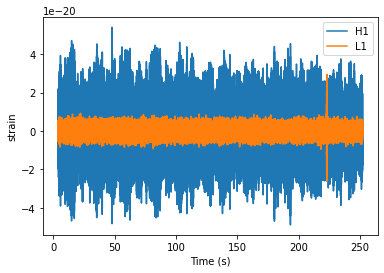

In [16]:
#Printing the sample times against the strains of the Hanford and Livingston data
pylab.plot(strain['H1'].sample_times, strain['H1'], label= 'H1')
pylab.plot(strain['L1'].sample_times, strain['L1'], label= 'L1')

pylab.legend()
pylab.xlabel('Time (s)')
pylab.ylabel('strain')
pylab.show()


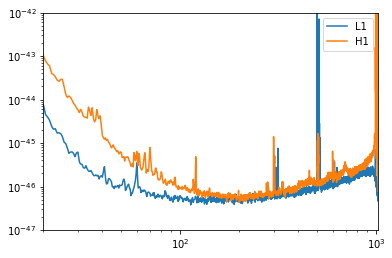

In [17]:
#Plotting the power spectral density of the data
import pycbc.psd
from pycbc.psd import interpolate

psds = {}
for ifo in ['L1', 'H1']:

    delta_t = strain[ifo].delta_t
    seg_len = int(2 / delta_t)
    seg_stride = int(seg_len / 2)
    psds[ifo]  = pycbc.psd.welch(strain[ifo],
                      seg_len=seg_len,
                      seg_stride=seg_stride)
    
    psds[ifo] = interpolate(psds[ifo], stilde[ifo].delta_f)

    #Plotting
    pylab.loglog(psds[ifo].sample_frequencies, psds[ifo], label = ifo)
    pylab.xlim(20, 1024)
    pylab.ylim(1e-47, 1e-42)
pylab.legend()


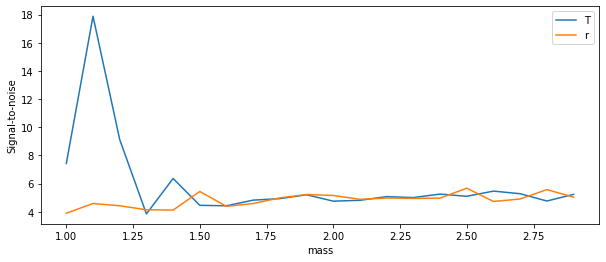

In [19]:
from pycbc.waveform import get_fd_waveform, get_td_waveform
from pycbc.filter import matched_filter
from pycbc.conversions import mass1_from_mchirp_q
import numpy

#Creating a Solar mass range between 1 and 3
mass1 = numpy.arange(1, 3,0.10 )
#Both masses are equal
mass2 = mass1

#Variables to store when the max is found
hmax, smax, tmax, mmax, nsnr = None, {}, {}, 0, 0
snrs = {}
ifo = 'H1'
Snr_list = []

#Generating a waveform
for i in range(len(mass1)):
 
    m = mass1[i] # Solar masses
    Hp, Hc = get_td_waveform(approximant="TaylorT2", 
                             mass1=m, 
                             mass2=m, 
                             delta_t=strain[ifo].delta_t, 
                             f_lower=15.0)

    #Resizing the vector to match the data
    Hp.resize(len(strain[ifo]))
    template = Hp.cyclic_time_shift(Hp.start_time)
    
    snr = matched_filter(template, strain[ifo],
                         psd=psds[ifo], low_frequency_cutoff=15.0)

    #Removing 4 seconds from the beginning and end for 
    #the PSD filtering as well as an additional 4 seconds 
    #from the beginning to account for the template length
    snr_H1 = snr.crop(4 + 4, 4)

    Snr_list.append(max(abs(snr_H1)))
snrs[ifo] = Snr_list

ifo = 'L1'
Snr_list = []

#Generating a waveform
for i in range(len(mass1)):
 
    m = mass1[i] # Solar masses
    hp, hc = get_td_waveform(approximant="TaylorT2",
                     mass1=m,
                     mass2=m,
                     delta_t=strain[ifo].delta_t,
                     f_lower=15.0)

    #Resizing the vector to match our data
    hp.resize(len(strain[ifo]))
    template = hp.cyclic_time_shift(hp.start_time)
    
    snr = matched_filter(template, strain[ifo],
                     psd=psds[ifo], low_frequency_cutoff=15.0)

    #Removing 4 seconds from the beginning and end 
    #for the PSD filtering as well as an additional 4 seconds 
    #from the beginning to account for the template length
    snr_H1 = snr.crop(4 + 4, 4)

    #Taking the absolute to have real values only
    Snr_list.append(max(abs(snr_H1)))
snrs[ifo] = Snr_list

#Plotting the figure
pylab.figure(figsize=[10, 4])
pylab.plot(mass1, snrs['H1'], label= 'H1')
pylab.plot(mass1, snrs['L1'], label= 'L1')
pylab.legend('True')
pylab.ylabel('Signal-to-noise')
pylab.xlabel('mass')
pylab.show()


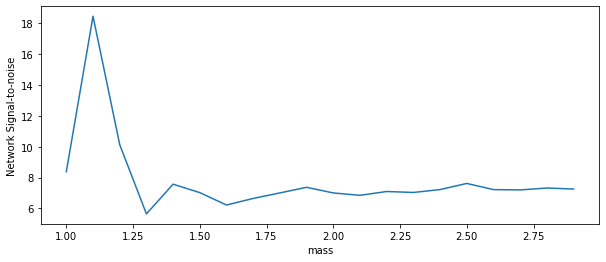

We found the best Mass1=Mass2 was 1.10 solar masses (detector frame)


In [20]:
#Creating the network signal to noise ratio
nsnr = (numpy.array(snrs['H1'])**2 + numpy.array(snrs['L1'])**2)**0.5
ii = numpy.where(nsnr == max(nsnr))
pylab.figure(figsize=[10, 4])
pylab.plot(mass1, nsnr)

#Plotting it
pylab.ylabel('Network Signal-to-noise')
pylab.xlabel('mass')
pylab.show()

print("We found the best Mass1=Mass2 was %2.2f solar masses (detector frame)" % mass1[ii])

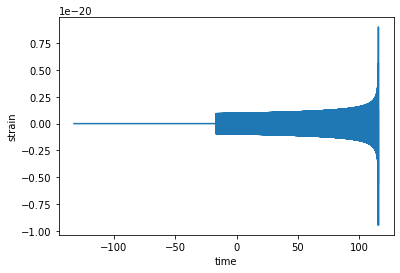

In [21]:
#Assuming equal masses, which is within the posterior probability
# of GW150914. 
m = 1.1 # Solar masses (Chirp mass)
conditioned = strain['H1']
HP, HC = get_td_waveform(approximant="TaylorT2",
                     mass1=m,
                     mass2=m,
                     delta_t=conditioned.delta_t,
                     f_lower=25.0)

#Resizing the vector to match the data
HP.resize(len(conditioned))

#Creating the template of the data
template = HP.cyclic_time_shift(HP.start_time)

#Plotting the strain against time
pylab.plot(HP.sample_times, template)
pylab.xlabel('time')
pylab.ylabel('strain')
pylab.show()

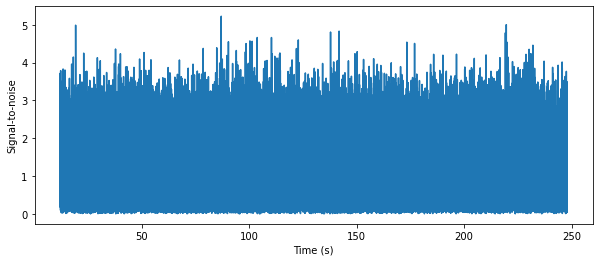

We found a signal at 87.04736328125s with SNR 5.225385227787452


In [22]:
from pycbc.filter import matched_filter
import numpy

ifo = 'L1'                            
conditioned = strain[ifo]
snr = matched_filter(template, conditioned,
                     psd=psds[ifo] , low_frequency_cutoff=25.0)

#Removing 4 seconds from the beginning and end for the PSD filtering as well as an additional 4 seconds from the beginning to account for the template length
snr = snr.crop(4 + 4, 4)

#Plotting by taking the absolute to have real values only
pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

#Setting the parameters
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, abs(snrp)))


In [23]:
from pycbc.filter import sigma

#Shifting the template to the peak time
dt = time - conditioned.start_time
aligned = template.cyclic_time_shift(dt)

#Scaling the template so that it would have SNR 1 in this data
aligned /= sigma(aligned, psd=psds[ifo], low_frequency_cutoff=20.0)

#Scaling the template amplitude and phase to the peak value
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries()
aligned.start_time = conditioned.start_time

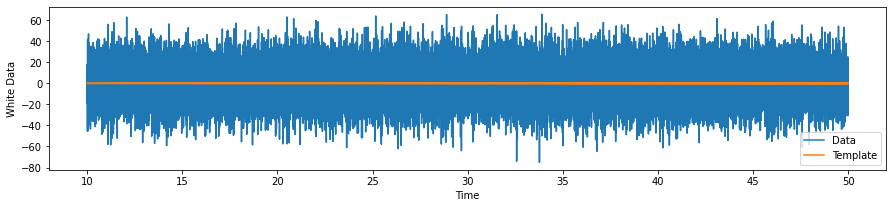

In [24]:
#Whitening both the template and the data
white_data = (conditioned.to_frequencyseries() / psds[ifo]**0.5).to_timeseries()

#Applying a smoothing of the turnon of the template to avoid a transient
# from the sharp turn on in the waveform.
tapered = aligned.highpass_fir(30, 512, remove_corrupted=False)
white_template = (tapered.to_frequencyseries() / psds[ifo]**0.5).to_timeseries()

white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
#white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

#Selecting the appropriate time around the merger
white_data = white_data.time_slice(10,50)
white_template = white_template.time_slice(10,50)

#Plotting the white data against time
pylab.figure(figsize=[15, 3])
pylab.plot(white_data.sample_times, white_data, label="Data")
pylab.plot(white_template.sample_times, white_template, label="Template")
pylab.ylabel("White Data")
pylab.xlabel("Time")
pylab.legend()
pylab.show()

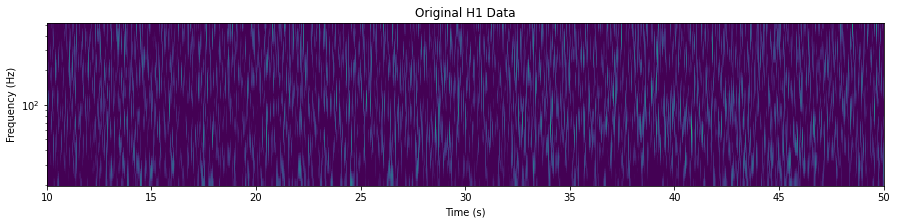

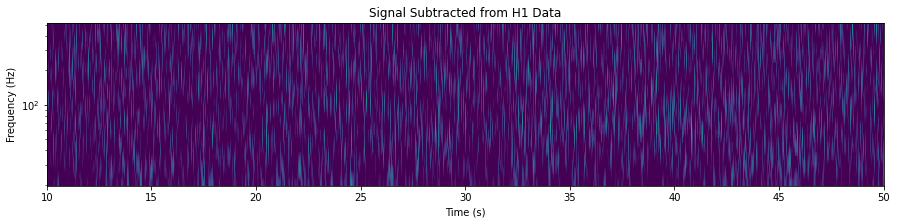

In [25]:
#Plotting the original and subtracted signal data
subtracted = conditioned - aligned

for data, title in [(conditioned, 'Original H1 Data'),
                    (subtracted, 'Signal Subtracted from H1 Data')]:

    t, f, p = data.whiten(4, 4).qtransform(.001,
                                                  logfsteps=100,
                                                  qrange=(8, 8),
                                                  frange=(20, 512))
    pylab.figure(figsize=[15, 3])
    pylab.title(title)
    pylab.pcolormesh(t, f, p**0.5, vmin=1, vmax=6)
    pylab.yscale('log')
    pylab.xlabel('Time (s)')
    pylab.ylabel('Frequency (Hz)')
    pylab.xlim(10, 50)
    pylab.show()


**Part 3**

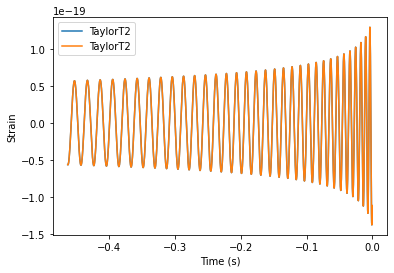

In [26]:
#Problem 1 part 3
#Let's generate a waveform for mass1 = mass2 = 10
for approxx in ['TaylorT2', 'TaylorT2']:
    hP, hC = get_td_waveform(approximant=approxx,mass1=10, mass2=10, spin1z=0, delta_t=1.0/4096, f_lower=50)

    pylab.plot(hP.sample_times, hP, label=approxx)

pylab.ylabel('Strain')
pylab.xlabel('Time (s)')

pylab.legend()
pylab.show()

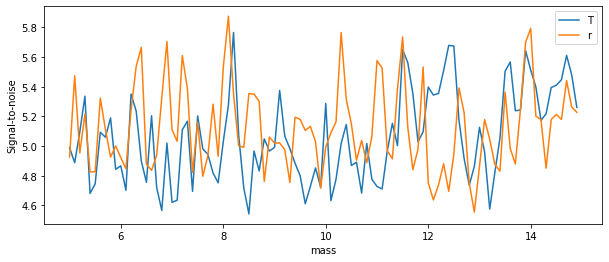

In [27]:
#Now let's generate a set of waveforms between 5 and 15 solar masses
mass1 = numpy.arange(5, 15,0.10 )
mass2 = mass1

#Variables to store when the max is found
hmax, smax, tmax, mmax, nsnr = None, {}, {}, 0, 0
snrs = {}
ifo = 'H1'
Snr_list = []

#Generating a waveform
for i in range(len(mass1)):
 
    m = mass1[i] # Solar masses
    hp, hc = get_td_waveform(approximant="TaylorT2", 
                             mass1=m, 
                             mass2=m, 
                             delta_t=strain[ifo].delta_t, 
                             f_lower=15.0)

    #Resizing the vector to match the data
    hp.resize(len(strain[ifo]))
    template = hp.cyclic_time_shift(hp.start_time)
    
    snr = matched_filter(template, strain[ifo],psd=psds[ifo], 
                         low_frequency_cutoff=15.0)

    #Removing 4 seconds from the beginning and end for the PSD filtering as well as an additional 4 seconds from the beginning to account for the template length
    snr_H1 = snr.crop(4 + 4, 4)


    Snr_list.append(max(abs(snr_H1)))
snrs[ifo] = Snr_list

ifo = 'L1'
Snr_list = []

#Generating a waveform
for i in range(len(mass1)):
 
    m = mass1[i] # Solar masses
    hp, hc = get_td_waveform(approximant="TaylorT2",
                     mass1=m,
                     mass2=m,
                     delta_t=strain[ifo].delta_t,
                     f_lower=15.0)

    #Resizing the vector to match the data
    hp.resize(len(strain[ifo]))
    template = hp.cyclic_time_shift(hp.start_time)
    
    snr = matched_filter(template, strain[ifo],
                     psd=psds[ifo], low_frequency_cutoff=15.0)
    #Removing 4 seconds from the beginning and end for the PSD filtering as well as an additional 4 seconds from the beginning to account for the template length
    snr_H1 = snr.crop(4 + 4, 4)

    #Taking the absolute to have real values only
    Snr_list.append(max(abs(snr_H1)))
snrs[ifo] = Snr_list

#Plotting
pylab.figure(figsize=[10, 4])
pylab.plot(mass1, snrs['H1'], label= 'H1')
pylab.plot(mass1, snrs['L1'], label= 'L1')
pylab.legend('True')
pylab.ylabel('Signal-to-noise')
pylab.xlabel('mass')
pylab.show()

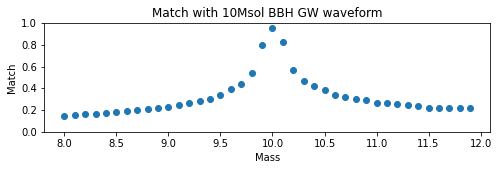

In [28]:
from pycbc.waveform import get_td_waveform
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower 
f_low = 30 
sample_rate = 4096
 
#Generating the two waveforms to compare 
hp, hc = get_td_waveform(approximant = "EOBNRv2", 
                         mass1 = 10, 
                         mass2 = 10, 
                         f_lower = f_low, 
                         delta_t = 1.0/sample_rate)
Mass_list = []
Match_list = []
for Mass in range(80,120):
  Massf = Mass / 10
  sp, sc = get_td_waveform(approximant = "TaylorT4", 
                           mass1 = Massf, 
                           mass2 = Massf, 
                           f_lower = f_low, 
                           delta_t = 1.0/sample_rate) 
 
  #Resizing the waveforms to the same length
  tlen = max(len(sp), len(hp)) 
  sp.resize(tlen) 
  hp.resize(tlen) 
 
  #Generating the aLIGO ZDHP PSD 
  delta_f = 1.0/sp.duration
  flen = tlen//2+1 
  psd = aLIGOZeroDetHighPower(flen, delta_f, f_low) 
  m, i = match(hp,sp, psd=psd, low_frequency_cutoff = f_low)

  Mass_list = np.append(Mass_list, Massf)
  Match_list = np.append(Match_list, m)

x = np.array(Mass_list)
y = np.array(Match_list)

pylab.figure(figsize = [8,2])
plt.scatter(x,y)
pylab.title("Match with 10Msol BBH GW waveform")
pylab.xlabel("Mass")
pylab.ylabel("Match")
pylab.ylim(0,1)
pylab.show()


# **Problem 2**

**Part 1**

In [29]:
#Problem 2 part 1

#Reading the second dataset from LIGO Hanford
data2 = np.load('/content/drive/MyDrive/PRA3024 data/noise_ts_4096Hz.npy')

#Retrieving the Time and Strain data from the file
Time = data2[:, 0]
Strain = data2[:,1]

#Converting the data into time series data
import pycbc.types
DT = Time[1]-Time[0]
Data = pycbc.types.TimeSeries(data2[:,1], delta_t=DT)




In [30]:
#Generating a waveform for Soalr masses between 5 and 10
mass1 = numpy.arange(5, 10,0.10 )
mass2 = mass1

#Variables to store when the max is found
hmax, smax, tmax, mmax, nsnr = None, {}, {}, 0, 0
snrs = {}
ifo = 'H1'
Snr_list = []

#Generating a waveform
for i in range(len(mass1)):
 
    m = mass1[i] # Solar masses
    hp, hc = get_td_waveform(approximant="TaylorT2",
                     mass1=m,
                     mass2=m,
                     delta_t=strain[ifo].delta_t,
                     f_lower=15.0)

    # Resizing the vector to match the data
    hp.resize(len(strain[ifo]))

    #template  - k(t), filter
    template = hp.cyclic_time_shift(hp.start_time)
    
    #Filtering the template
    snr = matched_filter(template, strain[ifo],
                         
                     #power spectral density (frequency corresponds to previously chosen frequency)
                     psd=psds[ifo], low_frequency_cutoff=15.0)

    #Removing 4 seconds from the beginning and end for the PSD filtering as well as an additional 4 seconds from the beginning to account for the template length
    snr_H1 = snr.crop(4 + 4, 4)


    Snr_list.append(max(abs(snr_H1)))
snrs[ifo] = Snr_list

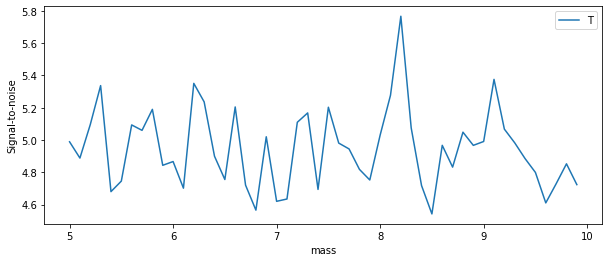

In [31]:
#Plotting the data
pylab.figure(figsize=[10, 4])
pylab.plot(mass1, snrs['H1'], label= 'H1')
pylab.legend('True')
pylab.ylabel('Signal-to-noise')
pylab.xlabel('mass')
pylab.show()

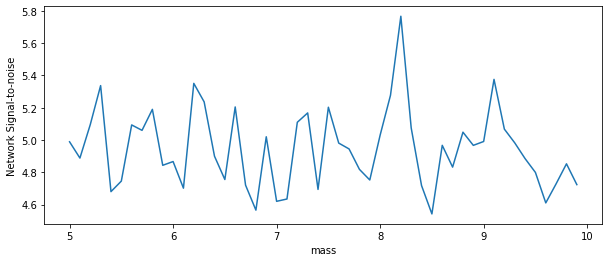

We found the best Mass1=Mass2 was 8.20 solar masses (detector frame)


In [32]:
#Creating the network SNR
nsnr = (numpy.array(snrs['H1'])**2)**0.5
ii = numpy.where(nsnr == max(nsnr))
pylab.figure(figsize=[10, 4])
pylab.plot(mass1, nsnr)

#Plotting
pylab.ylabel('Network Signal-to-noise')
pylab.xlabel('mass')
pylab.show()

print("We found the best Mass1=Mass2 was %2.2f solar masses (detector frame)" % mass1[ii])

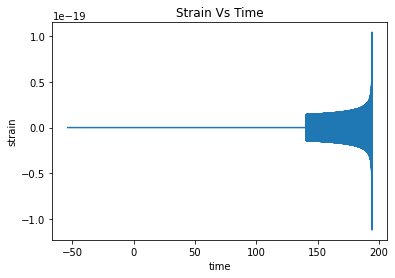

In [33]:
#Getting the strain Vs time

m = 8.20 # Solar masses
conditioned = strain['H1']
hp, hc = get_td_waveform(approximant="TaylorT2",
                     mass1=m,
                     mass2=m,
                     delta_t=conditioned.delta_t,
                     f_lower=10.0)

# Resizing the vector to match the data
hp.resize(len(conditioned))

#Getting the template
template = hp .cyclic_time_shift(hp.start_time)

#Plotting the straing against the time
pylab.plot(hp.sample_times, template)
pylab.xlabel('time')
pylab.ylabel('strain')
pylab.title("Strain Vs Time")
pylab.show()

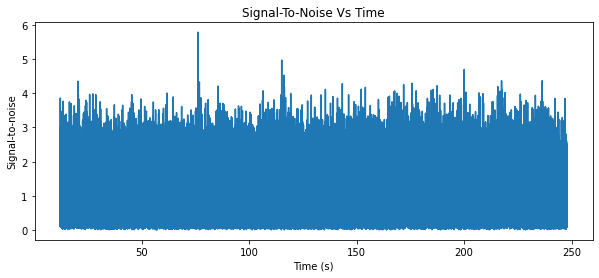

We found a signal at 76.17822265625s with SNR 5.787233530233416
The data provided has only noise and no signal


In [34]:
ifo = 'H1'                            
conditioned = strain[ifo]
snr = matched_filter(template, conditioned,
                     psd=psds[ifo] , low_frequency_cutoff=20)
#Removing 4 seconds from the beginning and end for the PSD filtering as well as an additional 4 seconds from the beginning to account for the template length
snr = snr.crop(4 + 4, 4)

#Plotting the absolute SNR to have real values only against time
pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.title("Signal-To-Noise Vs Time")
pylab.show()

#Setting the parameters
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, abs(snrp)))

print("The data provided has only noise and no signal")

**Part 2**

The mean of this gaussian distribution is -0.0012617893627702634


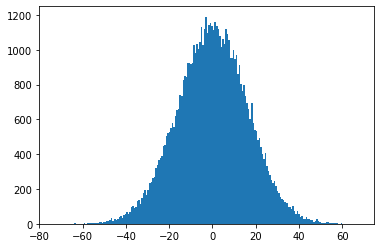

In [35]:
#Problem 2 part 2
#Whitening the data

import pycbc.psd
from pycbc.psd import interpolate

Psds = {}
for ifo in ['H1']:


    delta_t = strain[ifo].delta_t
    #segmrnting the data into quantized units
    seg_len = int(2 / delta_t)
    seg_stride = int(seg_len / 2)
    Psds[ifo]  = pycbc.psd.welch(strain[ifo],
                      seg_len=seg_len,
                      seg_stride=seg_stride)
    
    Psds[ifo] = interpolate(psds[ifo], stilde[ifo].delta_f)

# We do it this way so that we can whiten both the template and the data
white_data = (conditioned.to_frequencyseries() / psds[ifo]**0.5).to_timeseries()

# apply a smoothing of the turnon of the template to avoid a transient
# from the sharp turn on in the waveform.
tapered = aligned.highpass_fir(30, 512, remove_corrupted=False)
white_template = (tapered.to_frequencyseries() / psds[ifo]**0.5).to_timeseries()

white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
#white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

# Select the time around the merger
white_data = white_data.time_slice(10, 50)
white_template = white_template.time_slice(10, 50)

white_data = white_data.crop(4,4)

import statistics
import matplotlib.pyplot as plt

plt.hist(white_data,bins = 200)

print("The mean of this gaussian distribution is " + str(statistics.mean(white_data)))


**Part 3**

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([3.52894338, 3.62894338, 3.72894338, 3.82894338, 3.92894338,
        4.02894338, 4.12894338, 4.22894338, 4.32894338, 4.42894338,
        4.52894338]),
 <BarContainer object of 10 artists>)

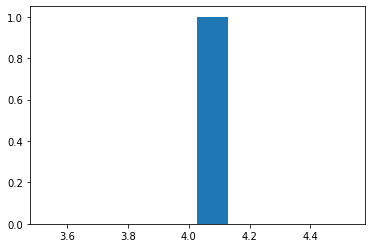

In [37]:
#Problem 2 part 3
from scipy.optimize._lsq.common import print_header_nonlinear

#Testing whether the noise follows the stationary assumption or not
#Calculating the optimal SNR
from pycbc.filter import sigmasq

from pycbc.waveform import get_fd_waveform 


hp, hc = get_fd_waveform(approximant="TaylorF2", 
                         mass1=3, 
                         mass2=3, 
                         delta_f=0.004032258064516129 , 
                         distance = 500,  
                         f_lower=20.0, f_final = 2048.0)    #Luminosity distance = 500 Mpc
  
#Creating the SNR
psd = psds[ifo]
SNR = (pycbc.filter.sigmasq(hp[0:253951], psd))**0.5                    

#Plotting the SNR
plt.hist(SNR)

# **Problem 3**

**Part 1**

Text(0, 0.5, 'Power Spectral Density')

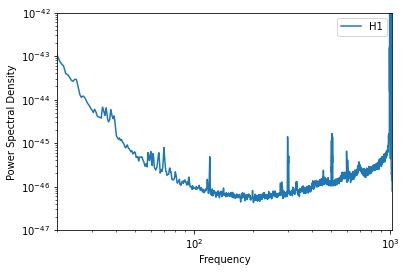

In [38]:
#Problem 3 part 1

import pycbc.psd 
import numpy as np 
flow = 4.0   # set up the lower cut off frequency 
delta_f = 1.0 / 16 
flen = int(2048.0/ (delta_f)) + 1 
psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow) 
 
psd.data[:int(flow/delta_f)] = np.inf  #set the value outside the frequency range to infinity 
psd.data[-1] = np.inf 

#Plotting the power spectral density of the data
import pycbc.psd
from pycbc.psd import interpolate

psds = {}
for ifo in ['H1']:


    delta_t = strain[ifo].delta_t
    #segmrnting the data into quantized units
    seg_len = int(2 / delta_t)
    seg_stride = int(seg_len / 2)
    psds[ifo]  = pycbc.psd.welch(strain[ifo],
                      seg_len=seg_len,
                      seg_stride=seg_stride)
    
    psds[ifo] = interpolate(psds[ifo], stilde[ifo].delta_f)

    pylab.loglog(psds[ifo].sample_frequencies, psds[ifo], label=ifo)
    pylab.xlim(20, 1024)
    pylab.ylim(1e-47, 1e-42)
pylab.legend()
pylab.xlabel("Frequency")
pylab.ylabel("Power Spectral Density")
 

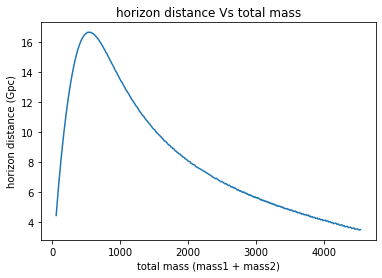

In [39]:
#Setting the range of masses of the binary system
mass_one = np.arange(5, 500, 1)
#mass1 = mass2

#Creating empty array to store the wanted SNR and the corresponding total mass
Appropriate_snr = []
Total_mass = []

#Generating a waveform
for i in mass_one:
  hp, hc = pycbc.waveform.get_fd_waveform(approximant="TaylorF2",
    mass1=i, mass2=i,
    f_lower=4.0,
    delta_f=1.0 / 16,
    distance = 1000)
  
  #Creating the SNR
  SNR = (pycbc.filter.sigmasq(hp, psd))**0.5

  #Data is stored only if SNR fits the criteria
  if SNR > 8:
    Appropriate_snr.append(SNR/2.3)
    Total_mass.append(i*12)

#Plotting the data
pylab.plot(Total_mass, Appropriate_snr, label = "aLIGO")
pylab.ylabel("horizon distance (Gpc)")
pylab.xlabel("total mass (mass1 + mass2)")
pylab.title("horizon distance Vs total mass")
pylab.show()
     
     


**Problem 3 part 2**
Every detector has a different range of frequencies which it is capable of detecting, which means that each detector has a different optimal signal to noise ratio. As the frequency increases as mass increases, detectors without the capability of detecting high frequencies will not be able to detect high masses well. Which is what causing the drop in the figure from part 1.

**Part 3**

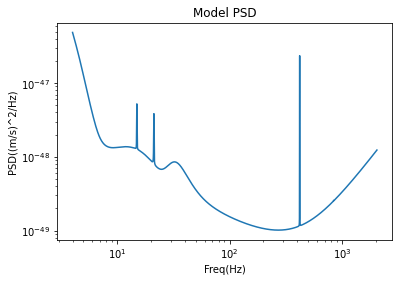

In [40]:
#Problem 3 part 3
import pycbc.psd 
import numpy as np 

flow = 4.0   # set up the lower cut off frequency 
delta_f = 1.0 / 16 
flen = int(2048.0/ (delta_f)) + 1 
psd = pycbc.psd.EinsteinTelescopeP1600143(flen, delta_f, flow) 
 
psd.data[:int(flow/delta_f)] = np.inf  #set the value outside the frequency range to infinity 
psd.data[-1] = np.inf

#Plotting the data
pylab.loglog(psd.sample_frequencies, psd.data)
pylab.ylabel("PSD((m/s)^2/Hz)")
pylab.xlabel("Freq(Hz)")
pylab.title("Model PSD")
pylab.show()

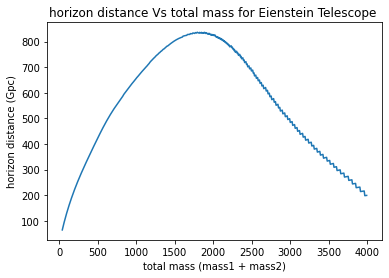

In [41]:
#Setting the range of masses of the binary system
mass_one = np.arange(5, 500, 1)
#mass1 = mass2

#Creating empty array to store the wanted SNR and the corresponding total mass
Appropriate_snr = []
Total_mass = []

#Generating a waveform
for i in mass_one:
  hp, hc = pycbc.waveform.get_fd_waveform(approximant="TaylorF2",
    mass1=i, mass2=i,
    f_lower=4.0,
    delta_f=1.0 / 16,
    distance = 1000)
  
  #Creating the SNR
  SNR = (pycbc.filter.sigmasq(hp, psd))**0.5

  #Data is stored only if SNR fits the criteria
  if SNR > 8:
    Appropriate_snr.append(SNR/2.3)
    Total_mass.append(i*8)

#Plotting the data
pylab.plot(Total_mass, Appropriate_snr, label = "ET")
pylab.ylabel("horizon distance (Gpc)")
pylab.xlabel("total mass (mass1 + mass2)")
pylab.title("horizon distance Vs total mass for Eienstein Telescope ")
pylab.show()

**My Conclusion**
The Einstein Telescope has a wider range of frequencies as compared to aLIGO, threfore it can detect both lower and higher frequencies, giving it a "dome" like shape and allowing it to detect higher masses. 